Data loaded successfully!
Number of clients: 7
--- Round 1 ---
--- Round 2 ---
--- Round 3 ---
--- Round 4 ---
--- Round 5 ---
--- Round 6 ---
--- Round 7 ---
--- Round 8 ---
--- Round 9 ---
--- Round 10 ---

--- Global Model Evaluation ---
Client 1 Accuracy: 0.7219
Client 1 ROC AUC: 0.7856
Client 1 Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.73      0.70        66
           1       0.77      0.72      0.74        85

    accuracy                           0.72       151
   macro avg       0.72      0.72      0.72       151
weighted avg       0.73      0.72      0.72       151

Client 2 Accuracy: 0.5333
Client 2 ROC AUC: 0.6429
Client 2 Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.50      0.53         8
           1       0.50      0.57      0.53         7

    accuracy                           0.53        15
   macro avg       0.54      0.54      0.53     

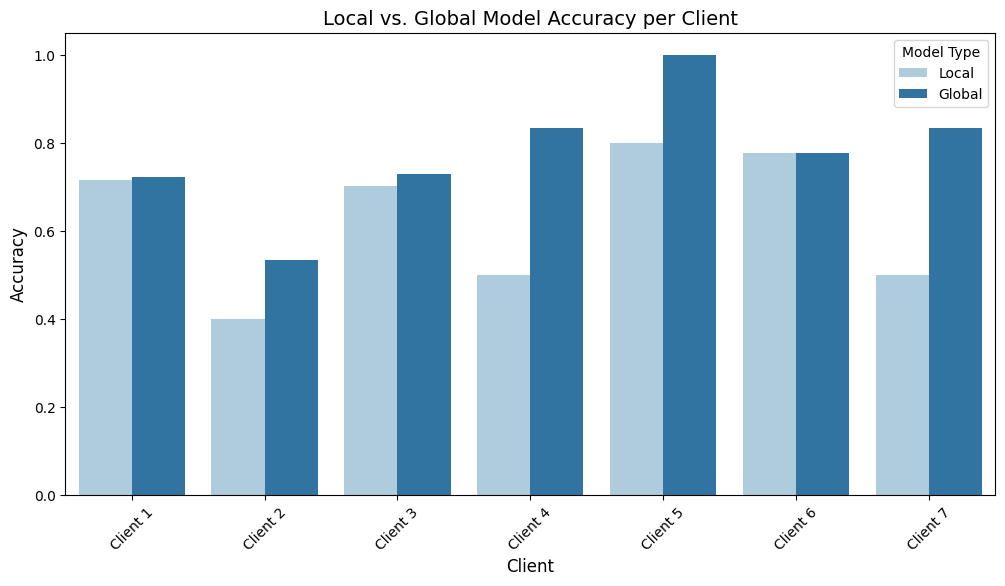

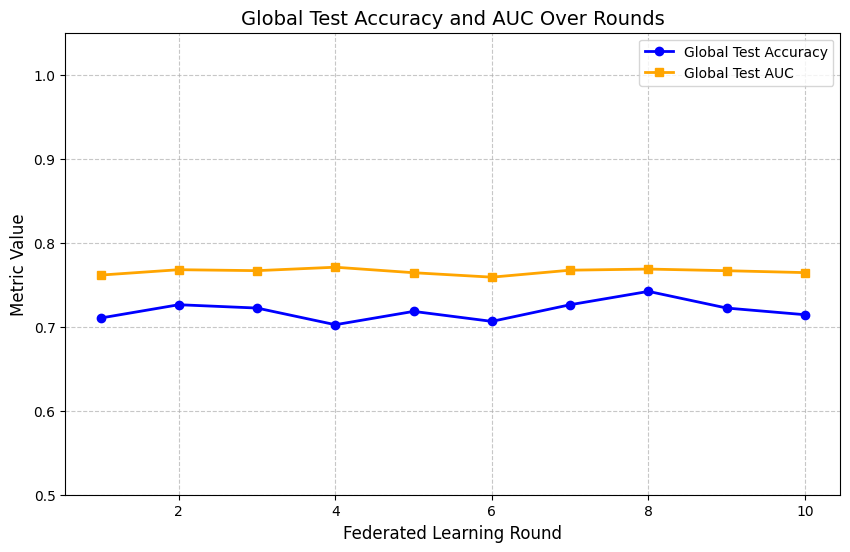

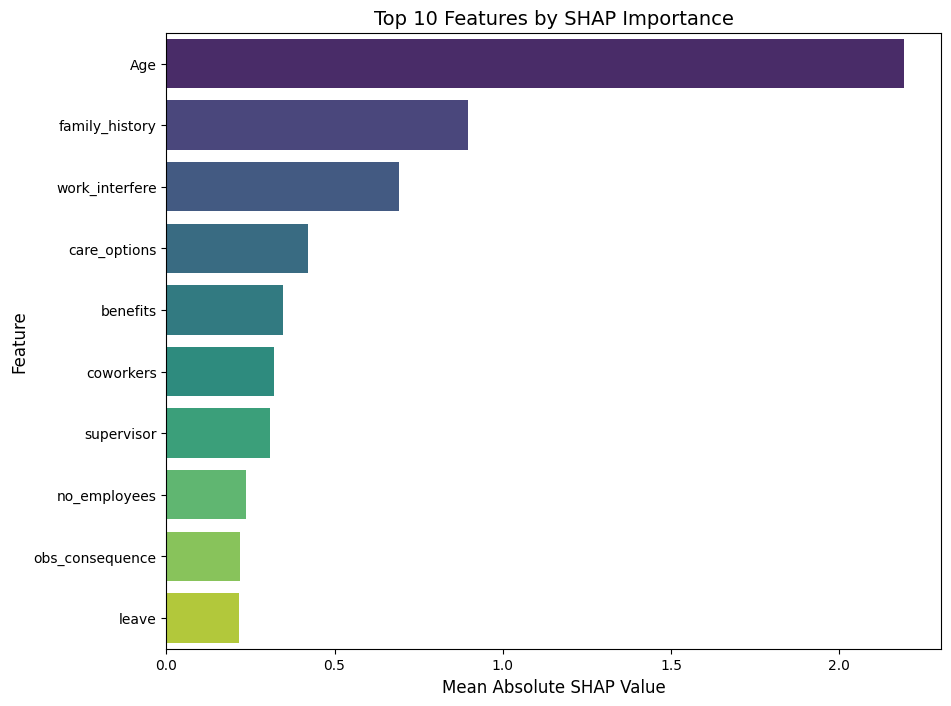

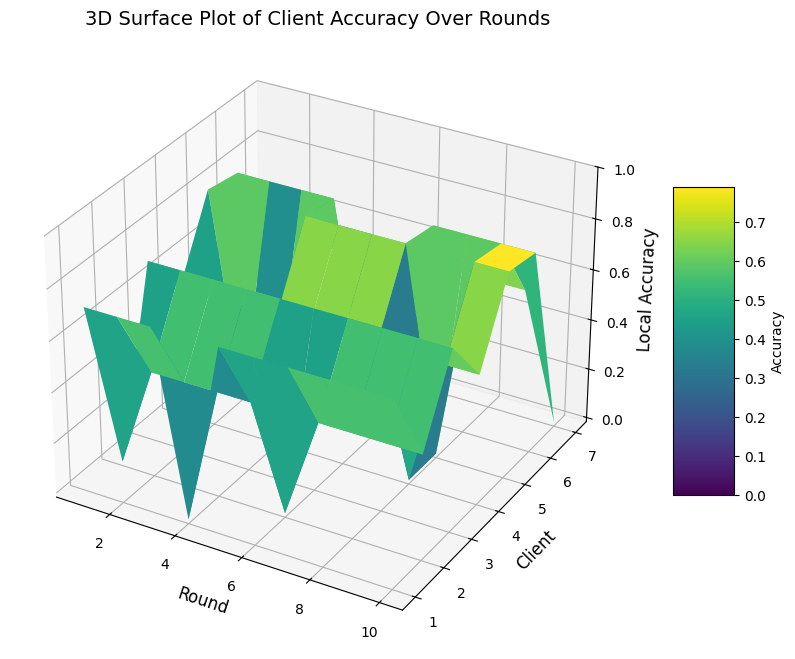

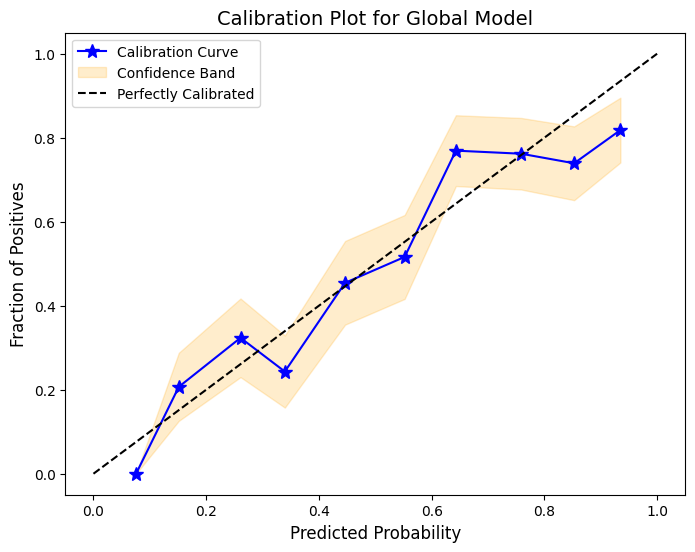

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, log_loss
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.calibration import calibration_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import shap
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")


np.random.seed(42)

df = pd.read_csv("/content/survey.csv")
print("Data loaded successfully!")


df.drop(columns=['state', 'comments'], inplace=True)


for column in df.select_dtypes(include='object'):
    df[column] = df[column].fillna(df[column].mode()[0])


def clean_gender(gender):
    gender = str(gender).lower()
    if "f" in gender:
        return "Female"
    elif "m" in gender:
        return "Male"
    else:
        return "Other"
df['Gender'] = df['Gender'].apply(clean_gender)


label_encoders = {}
categorical_cols = ['Gender', 'Country', 'self_employed', 'family_history', 'treatment', 'work_interfere',
                    'no_employees', 'remote_work', 'tech_company', 'benefits', 'care_options',
                    'wellness_program', 'seek_help', 'anonymity', 'leave', 'mental_health_consequence',
                    'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview',
                    'phys_health_interview', 'mental_vs_physical', 'obs_consequence']
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])

df['treatment'] = df['treatment'].astype(int)

features = ['Age', 'Gender', 'family_history', 'work_interfere', 'no_employees', 'remote_work', 'tech_company',
            'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave',
            'mental_health_consequence', 'phys_health_consequence', 'coworkers', 'supervisor',
            'mental_health_interview', 'phys_health_interview', 'mental_vs_physical', 'obs_consequence',
            'Country']
target = 'treatment'


X = df[features].values
y = df[target].values
X_train_global, X_test_global, y_train_global, y_test_global = train_test_split(X, y, test_size=0.2, random_state=42)


client_data = []
client_sizes = []
for country in df['Country'].unique():
    client_df = df[df['Country'] == country]
    if len(client_df) < 10:
        continue
    X_client = client_df[features].values
    y_client = client_df[target].values
    X_train, X_test, y_train, y_test = train_test_split(X_client, y_client, test_size=0.2, random_state=42)

    smote = SMOTE(random_state=42, k_neighbors=min(5, len(y_train)-1))
    try:
        X_train, y_train = smote.fit_resample(X_train, y_train)
    except ValueError:
        continue


    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    client_data.append(((X_train, y_train), (X_test, y_test)))
    client_sizes.append(len(y_train))

print(f"Number of clients: {len(client_data)}")


def federated_averaging(client_data, num_rounds=10, noise_scale=0.01):
    n_features = client_data[0][0][0].shape[1]
    global_model = LogisticRegression(solver='liblinear', random_state=42)
    global_model.coef_ = np.zeros((1, n_features))
    global_model.intercept_ = np.zeros(1)
    global_model.classes_ = np.array([0, 1])

    train_losses = []
    local_accuracies = [[] for _ in range(len(client_data))]
    local_roc_aucs = [[] for _ in range(len(client_data))]
    global_accuracies = []
    global_aucs = []
    client_participation = [[] for _ in range(len(client_data))]

    for round_num in range(num_rounds):
        print(f"--- Round {round_num + 1} ---")
        client_weights = []
        client_intercepts = []
        client_sizes_round = []
        round_losses = []

        for client_idx, ((X_train, y_train), (X_test, y_test)) in enumerate(client_data):
            if np.random.rand() > 0.2:
                local_model = LogisticRegression(solver='liblinear', random_state=42)
                local_model.fit(X_train, y_train)


                noisy_weights = local_model.coef_ + np.random.normal(0, noise_scale, local_model.coef_.shape)
                noisy_intercept = local_model.intercept_ + np.random.normal(0, noise_scale)

                client_weights.append(noisy_weights)
                client_intercepts.append(noisy_intercept)
                client_sizes_round.append(len(y_train))

                y_prob = local_model.predict_proba(X_train)[:, 1]
                loss = log_loss(y_train, y_prob)
                round_losses.append(loss)


                y_pred = local_model.predict(X_test)
                accuracy = accuracy_score(y_test, y_pred)
                local_accuracies[client_idx].append(accuracy)

                y_prob = local_model.predict_proba(X_test)[:, 1]
                fpr, tpr, _ = roc_curve(y_test, y_prob)
                roc_auc = auc(fpr, tpr)
                local_roc_aucs[client_idx].append(roc_auc)

                client_participation[client_idx].append(1)
            else:
                local_accuracies[client_idx].append(np.nan)
                local_roc_aucs[client_idx].append(np.nan)
                round_losses.append(np.nan)
                client_participation[client_idx].append(0)


        if client_weights:
            total_size = sum(client_sizes_round)
            global_model.coef_ = np.average(client_weights, axis=0, weights=client_sizes_round)
            global_model.intercept_ = np.average(client_intercepts, axis=0, weights=client_sizes_round)


        y_pred_global = global_model.predict(X_test_global_scaled)
        global_acc = accuracy_score(y_test_global, y_pred_global)
        global_accuracies.append(global_acc)
        y_prob_global = global_model.predict_proba(X_test_global_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test_global, y_prob_global)
        global_auc = auc(fpr, tpr)
        global_aucs.append(global_auc)

        train_losses.append(round_losses)

    return global_model, train_losses, local_accuracies, local_roc_aucs, global_accuracies, global_aucs, client_participation


scaler_global = StandardScaler()
X_test_global_scaled = scaler_global.fit_transform(X_test_global)
global_model, train_losses, local_accuracies, local_roc_aucs, global_accuracies, global_aucs, client_participation = federated_averaging(client_data, num_rounds=10, noise_scale=0.01)

print("\n--- Global Model Evaluation ---")
client_accuracies = []
client_roc_aucs = []

for i, ((X_train, y_train), (X_test, y_test)) in enumerate(client_data):
    y_pred = global_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    client_accuracies.append(accuracy)

    y_prob = global_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    client_roc_aucs.append(roc_auc)

    print(f"Client {i + 1} Accuracy: {accuracy:.4f}")
    print(f"Client {i + 1} ROC AUC: {roc_auc:.4f}")
    print(f"Client {i + 1} Classification Report:\n{classification_report(y_test, y_pred, zero_division=0)}")


y_pred_global = global_model.predict(X_test_global_scaled)
global_accuracy = accuracy_score(y_test_global, y_pred_global)
global_roc_auc = auc(*roc_curve(y_test_global, global_model.predict_proba(X_test_global_scaled)[:, 1])[:2])
print(f"\nGlobal Test Set Accuracy: {global_accuracy:.4f}")
print(f"Global Test Set ROC AUC: {global_roc_auc:.4f}")
print(f"Global Test Set Classification Report:\n{classification_report(y_test_global, y_pred_global, zero_division=0)}")

plt.figure(figsize=(12, 6))
clients = [f"Client {i + 1}" for i in range(len(client_accuracies))]
avg_local_accuracies = [np.nanmean(acc) for acc in local_accuracies]
df_acc = pd.DataFrame({
    'Client': clients + clients,
    'Accuracy': avg_local_accuracies + client_accuracies,
    'Type': ['Local'] * len(clients) + ['Global'] * len(clients)
})
sns.barplot(x='Client', y='Accuracy', hue='Type', data=df_acc, palette="Paired")
plt.xlabel("Client", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Local vs. Global Model Accuracy per Client", fontsize=14)
plt.legend(title="Model Type")
plt.ylim(0, 1.05)
plt.xticks(rotation=45)
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(range(1, len(global_accuracies) + 1), global_accuracies, marker='o', color='blue', linestyle='-', linewidth=2, label='Global Test Accuracy')
plt.plot(range(1, len(global_aucs) + 1), global_aucs, marker='s', color='orange', linestyle='-', linewidth=2, label='Global Test AUC')
plt.xlabel("Federated Learning Round", fontsize=12)
plt.ylabel("Metric Value", fontsize=12)
plt.title("Global Test Accuracy and AUC Over Rounds", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0.5, 1.05)
plt.show()


explainer = shap.LinearExplainer(global_model, X_train_global)
shap_values = explainer.shap_values(X_test_global_scaled)
shap_importance = pd.DataFrame({'Feature': features, 'Importance': np.abs(shap_values).mean(0)})
shap_importance = shap_importance.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=shap_importance.head(10), palette="viridis")
plt.xlabel("Mean Absolute SHAP Value", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.title("Top 10 Features by SHAP Importance", fontsize=14)
plt.show()


fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

X = np.arange(1, 11)
Y = np.arange(1, len(client_data) + 1)
X, Y = np.meshgrid(X, Y)
Z = np.array([[local_accuracies[client_idx][round_idx] if not np.isnan(local_accuracies[client_idx][round_idx]) else 0 for round_idx in range(10)] for client_idx in range(len(client_data))])


surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='Accuracy')
ax.set_xlabel('Round', fontsize=12)
ax.set_ylabel('Client', fontsize=12)
ax.set_zlabel('Local Accuracy', fontsize=12)
ax.set_title('3D Surface Plot of Client Accuracy Over Rounds', fontsize=14)
ax.set_zticks(np.arange(0, 1.1, 0.2))
plt.show()


y_prob_global = global_model.predict_proba(X_test_global_scaled)[:, 1]
prob_true, prob_pred = calibration_curve(y_test_global, y_prob_global, n_bins=10)
n_samples = len(y_test_global) // 10
std_err = np.sqrt(prob_true * (1 - prob_true) / n_samples)
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='*', markersize=10, color='blue', linestyle='-', label='Calibration Curve')
plt.fill_between(prob_pred, prob_true - std_err, prob_true + std_err, color='orange', alpha=0.2, label='Confidence Band')
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Perfectly Calibrated')
plt.xlabel("Predicted Probability", fontsize=12)
plt.ylabel("Fraction of Positives", fontsize=12)
plt.title("Calibration Plot for Global Model", fontsize=14)
plt.legend()
plt.show()
participation_counts = [sum(part) for part in client_participation]
contributions = [size * count for size, count in zip(client_sizes, participation_counts)]

total_contribution = sum(contributions)
contributions = [c / total_contribution * 100 for c in contributions]


labels = [f"Client {i + 1}" for i in range(len(client_data))] + ["Global Model"]
source = list(range(len(client_data)))
target = [len(client_data)] * len(client_data)
value = contributions

colors = sns.color_palette("Set2", len(client_data)).as_hex()

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=["#666666"] * len(client_data) + ["#333333"]
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=[colors[i] for i in range(len(client_data))]
    )
)])

fig.update_layout(
    title_text="Sankey Diagram of Client Contribution to Global Model",
    font_size=12,
    width=800,
    height=600
)
fig.show()